# Predicting whether a mushroom is safe to eat 
Wanting to gain more experience with neural nets, I came across a dataset on Kaggle consisting of poisonous and edibile mushrooms along with their physical characteristics like odor and shape. More information can be found at https://www.kaggle.com/uciml/mushroom-classification.

Included in the notebook are two classification methods: artificial neural networks and decision trees. I included the decision tree as it seemed to be the most obvious approach.

TL;DR conclusion: both classification models were excellent. The logloss for the neural net was minimal and the accuracy scores for both were near-perfect.

In [1]:
%matplotlib inline
#something else
import pandas as pd
import numpy as np
from time import time

In [2]:
#load df
df_shrooms = pd.read_csv('mushroom-classification/mushrooms.csv', dtype="category")
df_shrooms.shape

(8124, 23)

In [3]:
df_shrooms.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [29]:
def log_loss(target, output):
    if len(target) != len(output):
        raise ValueError('Target and Output lists of different lengths')
    err = 0
    for t, y in zip(target, output):
        err += np.log(y[0])*(1-t) + np.log(y[1])*t
    return err*-1.0/len(target)

def err2(target, output):
    if len(target) != len(output):
        raise ValueError('Target and Output lists of different lengths')
    err = 0
    for t, y in zip(target, output):
        err += (t-y)*(t-y)
    return err*1.0/len(target)

### Data preprocessing

In [5]:
#convert categorical data into numeric data
df_shrooms_num = df_shrooms.copy()
for var in df_shrooms_num:
    df_shrooms_num[var] = df_shrooms_num[var].cat.codes
df_shrooms_num['class'] = 2*df_shrooms_num['class'] - 1 #get classes as -1, +1

In [6]:
# get column headings from metadata
description = """cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
bruises: bruises=t,no=f
odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
gill-attachment: attached=a,free=f
gill-spacing: close=c,crowded=w
gill-size: broad=b,narrow=n
gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
stalk-shape: enlarging=e,tapering=t
stalk-root: bulbous=b,club=c,equal=e,rooted=r,missing=?
stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
veil-type: partial=p
veil-color: brown=n,orange=o,white=w,yellow=y
ring-number: none=n,one=o,two=t
ring-type: evanescent=e,flaring=f,large=l,none=n,pendant=p
spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d"""

columns = []
for line in description.splitlines():
        prefix, vars = line.strip().split(':')
        for v in vars.split(','):
            value, abbr = v.split('=')
            columns.append("{}:{}".format(prefix.strip(), value.strip()))

In [7]:
#encode categorical features
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X = enc.fit_transform(df_shrooms_num.iloc[:, 1:])
X = pd.DataFrame(X.todense(), columns=columns)
X['class'] = df_shrooms_num['class']

In [8]:
#split into training and test sets
n = X.shape[0]
df_shuffle = X.sample(frac=1.0, random_state=int(time()))
df_train, df_test = df_shuffle.iloc[0:int(np.floor(n*0.8),) :], df_shuffle.iloc[int(np.floor(n*0.8)):, :]

### Method 1: Neural Nets

In [135]:
#split into training and test sets
n = X.shape[0]
df_shuffle = X.sample(frac=1.0, random_state=int(time()))
df_train, df_test = df_shuffle.iloc[0:int(np.floor(n*0.8),) :], df_shuffle.iloc[int(np.floor(n*0.8)):, :]

1 2 3 4 5 6 7 8 9

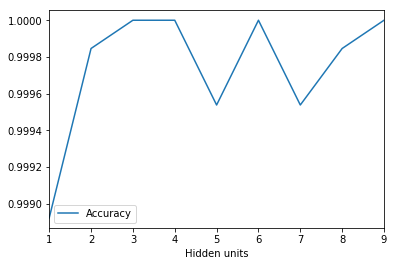

In [136]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

START, STOP = 1, 10
model_scores = []

for num_params in xrange(START, STOP, 1):
    print num_params,
    classifier = MLPClassifier(hidden_layer_sizes=(num_params,), alpha=0.01)
    s = cross_val_score(classifier, df_train.iloc[:, :-1], df_train['class'], cv=3)
    model_scores.append((num_params, np.average(s)))
    
pd.DataFrame(model_scores, columns=['Hidden units', 'Accuracy']).set_index('Hidden units').plot()

So, using 3 hidden units seems to work best. How does the model perform on the test case? 

In [131]:
classifier = MLPClassifier(hidden_layer_sizes=(num_params,), alpha=0.01)
classifier.fit(df_train.iloc[:, :-1], df_train['class'])
classifier.score(df_test.iloc[:, :-1], df_test['class'])

1.0

### Decision Tree

In [9]:
#split into training and test sets
n = X.shape[0]
df_shuffle = X.sample(frac=1.0, random_state=int(time()))
df_train, df_test = df_shuffle.iloc[0:int(np.floor(n*0.8),) :], df_shuffle.iloc[int(np.floor(n*0.8)):, :]

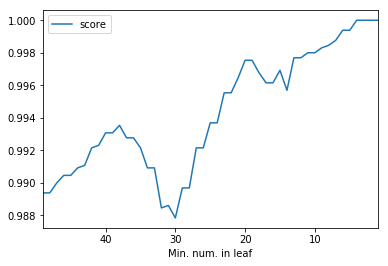

In [10]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

scores = []

for min_num_in_leaf in reversed(xrange(1, 50, 1)):
    clf = tree.DecisionTreeClassifier(min_samples_leaf=min_num_in_leaf)
    s = cross_val_score(clf, df_train.iloc[:,:-1], df_train['class'], cv=6)
    scores.append((min_num_in_leaf, np.average(s)))
    
pd.DataFrame(scores, columns=['Min. num. in leaf', 'score']).set_index('Min. num. in leaf').plot()

So, let's set a minimum leaf size of 3.

In [228]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=3)
clf.fit(df_train.iloc[:,:-1], df_train['class'])
clf.score(df_test.iloc[:, :-1], df_test['class'])

1.0

Perfectly classifies test set

Now, to print the tree. The labels indicate whether a particular attribute is absent. For example, for the root node, odor:musty<=0.5 is equivalent to the statement "Odor is NOT musty"

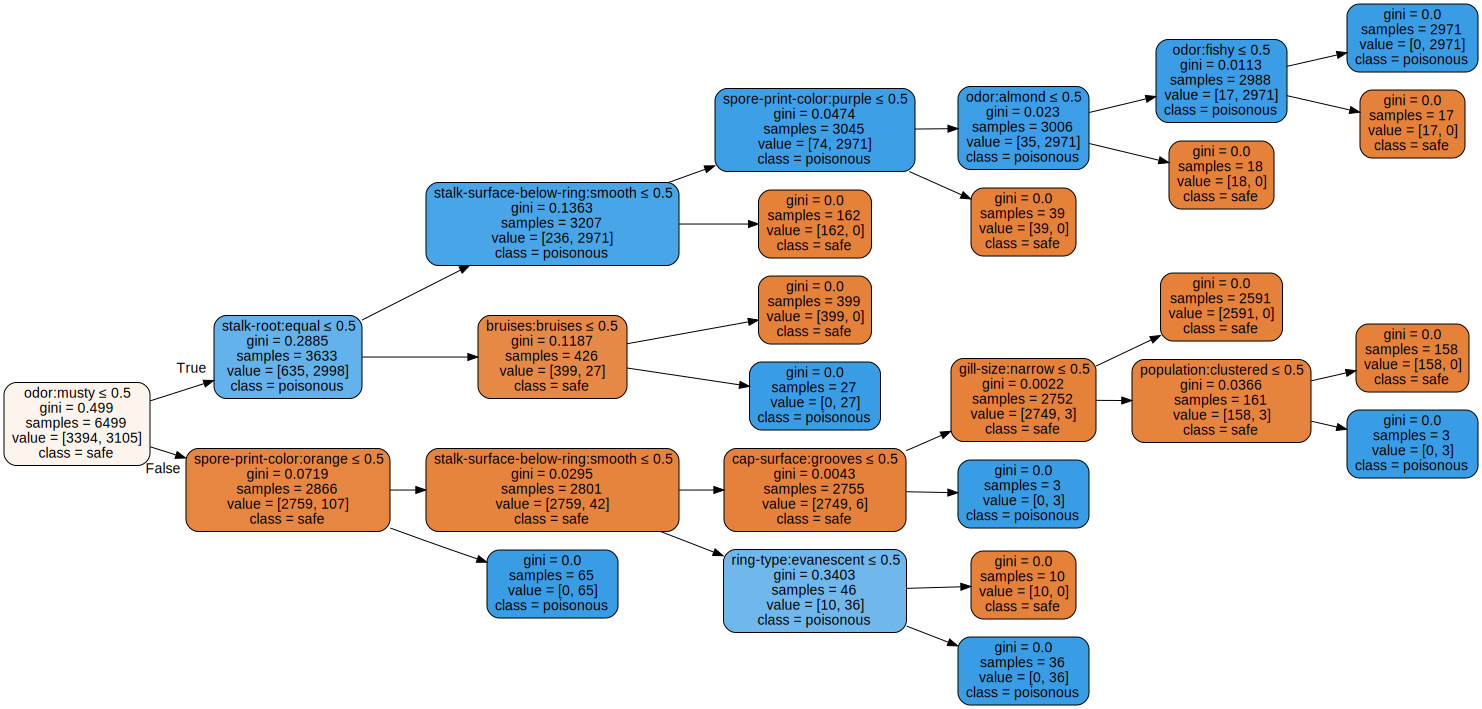

In [229]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=df_train.columns,  
                         class_names=['safe', 'poisonous'],  
                         filled=True, rounded=True,  
                         special_characters=True, rotate=True)  
graph = graphviz.Source(dot_data)  
graph

#### Improving the readability of the tree
For the root node, it would be more intuitive to ask "Does the mushroom have a musty odour?", as opposed to "Does the mushroom NOT have a must odour?" and, similarly, for the rest of the nodes. We can do this my simply switching the 0s to 1s, and vice versa, across all the variables in the training data. 

The code below also relabels the nodes and decreases fontsize.

In [227]:
df_train_hidden = df_train.iloc[:,:-1]
df_train_hidden = 1 - df_train_hidden
clf.fit(df_train_hidden, df_train['class'])


dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=df_train.columns,  
                         class_names=['safe', 'poisonous'],  
                         filled=True, rounded=True,  
                         special_characters=True, rotate=True)  

new_dot_data = ""

for line in dot_data.splitlines():
    i, j, k = line.find('[label='), line.find('&le'), line.find('<br/')
    if i!=-1 and line[i+8:i+12]!="gini":
            line = line[:i] + "[label=" + line[i+7:j-1] + "? " + line[k:]
    new_dot_data += line + "\n"
            
#reduce fontsize
i = dot_data.find('shape')
new_dot_data = new_dot_data[:i] + "fontsize=7, " + new_dot_data[i:]




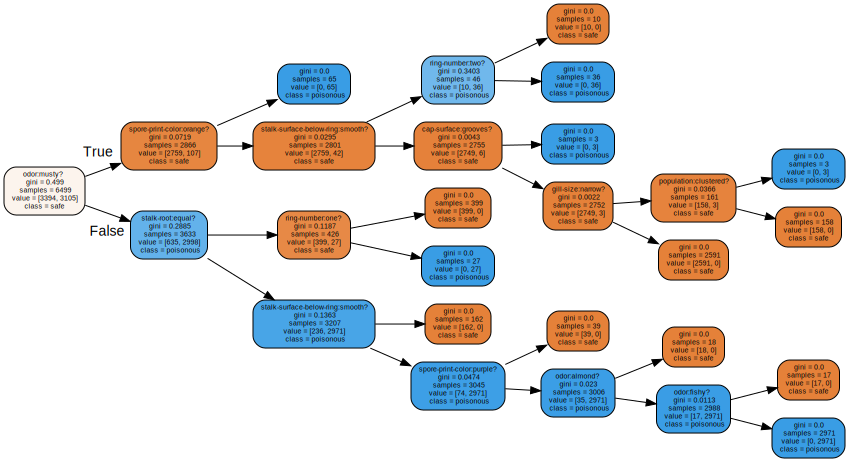

In [226]:
graph = graphviz.Source(new_dot_data)  
graph